# node2vec
---
[node2vec](http://snap.stanford.edu/node2vec/) for link prediction:
1. Train skip-gram model on random walks within graph
2. Get node embeddings from skip-gram
3. Test edge scores generated by these embeddings

**TODO: Generate edge embeddings via hadamard product**

node2vec source code: https://github.com/aditya-grover/node2vec

## 1. Read in Graph Data

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import scipy.sparse as sp
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score

In [2]:
EDGES_DIR = 'facebook/0.edges'

# Read edge-list
f = open(EDGES_DIR)
g_orig = nx.read_edgelist(f, nodetype=int)
g_adj = nx.to_numpy_matrix(g_orig) # convert to adjacency matrix (so node values become indices)
g = nx.from_numpy_matrix(g_adj) # re-create graph using node indices (0 to num_nodes-1)

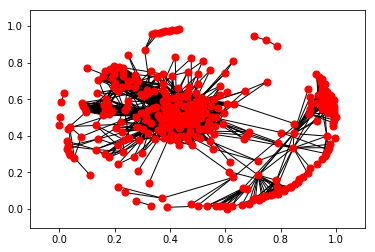

In [3]:
# draw network
nx.draw_networkx(g_orig, with_labels=False, node_size=50, node_color='r')
plt.show()

## 2. Preprocessing/Train-Test Split

In [4]:
from gae.preprocessing import mask_test_edges
np.random.seed(0) # make sure train-test split is consistent between notebooks
adj_sparse = nx.to_scipy_sparse_matrix(g)

# Perform train-test split
adj_train, train_edges, val_edges, val_edges_false, \
    test_edges, test_edges_false = mask_test_edges(adj_sparse, test_frac=.3, val_frac=.1)
g_train = nx.from_scipy_sparse_matrix(adj_train) # new graph object with only non-hidden edges

In [5]:
# Inspect train/test split
print "Total nodes:", adj_sparse.shape[0]
print "Total edges:", int(adj_sparse.nnz/2) # adj is symmetric, so nnz (num non-zero) = 2*num_edges
print "Training edges (positive):", len(train_edges)
print "Validation edges (positive):", len(val_edges)
print "Validation edges (negative):", len(val_edges_false)
print "Test edges (positive):", len(test_edges)
print "Test edges (negative):", len(test_edges_false)

Total nodes: 333
Total edges: 2519
Training edges (positive): 1513
Validation edges (positive): 251
Validation edges (negative): 251
Test edges (positive): 755
Test edges (negative): 755


In [6]:
def get_roc_score(edges_pos, edges_neg, embeddings):
    score_matrix = np.dot(embeddings, embeddings.T)
    
    def sigmoid(x):
        return 1 / (1 + np.exp(-x))
    
    # Store positive edge predictions, actual values
    preds_pos = []
    pos = []
    for edge in edges_pos:
        preds_pos.append(sigmoid(score_matrix[edge[0], edge[1]])) # predicted score
        pos.append(adj_sparse[edge[0], edge[1]]) # actual value (1 for positive)
        
    # Store negative edge predictions, actual values
    preds_neg = []
    neg = []
    for edge in edges_neg:
        preds_neg.append(sigmoid(score_matrix[edge[0], edge[1]])) # predicted score
        neg.append(adj_sparse[edge[0], edge[1]]) # actual value (0 for negative)
        
    # Calculate scores
    preds_all = np.hstack([preds_pos, preds_neg])
    labels_all = np.hstack([np.ones(len(preds_pos)), np.zeros(len(preds_neg))])
    roc_score = roc_auc_score(labels_all, preds_all)
    ap_score = average_precision_score(labels_all, preds_all)
    return roc_score, ap_score

## 3. Train node2vec (Learn Node Embeddings)

In [7]:
import node2vec
from gensim.models import Word2Vec

In [15]:
# node2vec settings
# NOTE: When p = q = 1, this is equivalent to DeepWalk

P = 1 # Return hyperparameter
Q = 1 # In-out hyperparameter
WINDOW_SIZE = 10 # Context size for optimization
NUM_WALKS = 10 # Number of walks per source
WALK_LENGTH = 80 # Length of walk per source
DIMENSIONS = 128 # Embedding dimension
DIRECTED = False # Graph directed/undirected
WORKERS = 8 # Num. parallel workers
ITER = 1 # SGD epochs

OUTPUT = 'node2vec/node2vec.emb'

In [9]:
# Preprocessing, generate walks
g_n2v = node2vec.Graph(g_train, DIRECTED, P, Q) # create node2vec graph instance
g_n2v.preprocess_transition_probs()
walks = g_n2v.simulate_walks(NUM_WALKS, WALK_LENGTH)
walks = [map(str, walk) for walk in walks]

# Train skip-gram model
model = Word2Vec(walks, size=DIMENSIONS, window=WINDOW_SIZE, min_count=0, sg=1, workers=WORKERS, iter=ITER)

# Store embeddings mapping
emb_mappings = model.wv

Walk iteration:
1 / 10
2 / 10
3 / 10
4 / 10
5 / 10
6 / 10
7 / 10
8 / 10
9 / 10
10 / 10


## 4. Evaluate Embeddings

In [10]:
# Create embeddings matrix (rows = nodes, columns = embedding features)
emb_list = []
for node_index in range(0, adj_sparse.shape[0]):
    node_str = str(node_index)
    node_emb = emb_mappings[node_str]
    emb_list.append(node_emb)
emb_matrix = np.vstack(emb_list)

In [11]:
# Calculate ROC AUC and Average Precision
n2v_roc, n2v_ap = get_roc_score(test_edges, test_edges_false, emb_matrix)

print 'node2vec Test ROC score: ', str(n2v_roc)
print 'node2vec Test AP score: ', str(n2v_ap)

node2vec Test ROC score:  0.752517872023
node2vec Test AP score:  0.691291592788


In [ ]:
# TODO:
# 1. For each edge in train_edges, generate/store edge embedding + positive label (1)
# 2. Sample an equal amount of truly non-existent edges. (Maybe do this in preprocessing.py? train_edges_false)
    # Generate/Store edge embeddings + negative label (0)
# 3. Train an sklearn logistic regression classifier: map edge-embedding --> edge score (0-1)
# 4. Evaluate edge scores on validation/training data (ROC AUC, AP)